In [3]:
# import fluidsynth
import glob
import numpy as np
import pandas as pd
import pretty_midi
import collections
from pathlib import Path
from IPython import display

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

%matplotlib inline
from matplotlib import pyplot as plt

# scrape time

In [162]:
import requests
from bs4 import BeautifulSoup
_datadir = Path('./data/classical')
def get_artist_link(tag):
    if tag.name != 'a':
        return False
    if tag.parent.name != 'td':
        return False
    if not tag.parent.has_attr('class'):
        return False
    if tag.parent.attrs['class'][0] == 'midi':
        return True
    return False

def get_files(tag):
    if tag.name != 'a':
        return False
    if tag.parent.name != 'td':
        return False
    if not tag.parent.has_attr('class'):
        return False
    if tag.parent.attrs['class'][0] != 'midi':
        return False
    if tag.has_attr('class'):
        return False
    href = tag.attrs['href']
    if href.split('/')[0] != 'midis':
        return False
    return True

root_url = 'http://www.piano-midi.de/'
base_url = f'{root_url}/midi_files.htm'
r = requests.get(base_url)
soup = BeautifulSoup(r.content, 'html.parser')
composer_page_link = soup.find_all(get_artist_link)
for composer_link in composer_page_link:
    composer_url = f'{root_url}/{composer_link.attrs["href"]}'
    r = requests.get(composer_url)
    soup = BeautifulSoup(r.content, 'html.parser') 
    file_tags = soup.find_all(get_files)
    for file_tag in file_tags:
        href = file_tag.attrs['href']
        filename = href.split('/')[-1]
        file_url = f'{root_url}/{href}'
        r = requests.get(file_url)
        with open(_datadir / filename, 'wb') as f:
            f.write(r.content)
        print(f'{filename} downloaded')

alb_esp1.mid downloaded
alb_esp2.mid downloaded
alb_esp3.mid downloaded
alb_esp4.mid downloaded
alb_esp5.mid downloaded
alb_esp6.mid downloaded
alb_se1.mid downloaded
alb_se2.mid downloaded
alb_se3.mid downloaded
alb_se4.mid downloaded
alb_se5.mid downloaded
alb_se6.mid downloaded
alb_se7.mid downloaded
alb_se8.mid downloaded
bach_846.mid downloaded
bach_847.mid downloaded
bach_850.mid downloaded
islamei.mid downloaded
beethoven_opus10_1.mid downloaded
beethoven_opus10_2.mid downloaded
beethoven_opus10_3.mid downloaded
pathetique_1.mid downloaded
pathetique_2.mid downloaded
pathetique_3.mid downloaded
beethoven_opus22_1.mid downloaded
beethoven_opus22_2.mid downloaded
beethoven_opus22_3.mid downloaded
beethoven_opus22_4.mid downloaded
mond_1.mid downloaded
mond_2.mid downloaded
mond_3.mid downloaded
waldstein_1.mid downloaded
waldstein_2.mid downloaded
waldstein_3.mid downloaded
appass_1.mid downloaded
appass_2.mid downloaded
appass_3.mid downloaded
beethoven_les_adieux_1.mid downloade

# load metadata

In [8]:
_datadir = Path('./data/classical')
_metadata_file = _datadir / 'metadata.csv'

if not _metadata_file.exists():
    files = collections.defaultdict(list)
    for filepath in _datadir.glob('*.mid'):
        files['file'].append(str(filepath))
        composer = filepath.stem.split('_')[0]
        files['composer'].append(composer)

        pm = pretty_midi.PrettyMIDI(str(filepath))
        files['end_time'].append(pm.get_end_time())
        
        
        tempos, probabilities = pm.estimate_tempi()
        assert np.isclose(sum(probabilities), 1)
        tempo_bpm = np.dot(tempos, probabilities) # expected tempo in beats/min
        seconds_per_beat = (1/tempo_bpm)*60
        time_sig_denom = pm.time_signature_changes[0].denominator
        note_dist = seconds_per_beat / (16 / time_sig_denom)
        
        files['expected_tempo'].append(tempo_bpm)
        files['16th_note_duration'].append(note_dist)

    df_meta = pd.DataFrame({ key: np.asarray(val) for key, val in files.items() })
    df_meta.to_csv(_metadata_file, index=False)
else:
    df_meta = pd.read_csv(_metadata_file)
    
df_meta.head()

,file,composer,end_time,expected_tempo,16th_note_duration
0,data/classical/beethoven_opus22_1.mid,beethoven,399.624004,164.101873,0.091407
1,data/classical/schub_d760_4.mid,schub,206.069698,240.133084,0.062465
2,data/classical/mz_330_3.mid,mz,482.101321,189.367179,0.079211
3,data/classical/beethoven_les_adieux_1.mid,beethoven,341.950341,214.732513,0.069854
4,data/classical/burg_spinnerlied.mid,burg,102.871024,277.682898,0.054018


# converting midi to audio

In [36]:
# Sampling rate for audio playback
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

# converting midi to pianoroll

In [15]:
def midi_to_pianoroll(file, sample_dist=0.02):
    pm = pretty_midi.PrettyMIDI(file)
    sampling_rate = 1/sample_dist
    piano_rolls = {}
    for instrument in pm.instruments:
        name = instrument.name
        rl = name.split(' ')[-1]
        if rl not in ['right', 'left']:
            continue
        piano_rolls[rl] = instrument.get_piano_roll(fs=sampling_rate)
    if len(piano_rolls) != 2:
        print('error!')
    return piano_rolls

In [16]:
sample_file = df_meta['file'][5]
pm = pretty_midi.PrettyMIDI(sample_file)
rolls = midi_to_pianoroll(df_meta['file'][5])

In [31]:
file_idx = 2

row = df_meta.loc[file_idx]

sample_file = row['file']


note_dist = row['16th_note_duration']

rolls = midi_to_pianoroll(sample_file, sample_dist=0.02)
elem_eq = np.equal(rolls['left'][:, 1:], rolls['left'][:, :-1])
frame_eq = np.all(elem_eq, axis=0)
print(np.sum(frame_eq)/len(frame_eq))

rolls = midi_to_pianoroll(sample_file, sample_dist=note_dist)
elem_eq = np.equal(rolls['left'][:, 1:], rolls['left'][:, :-1])
frame_eq = np.all(elem_eq, axis=0)
print(np.sum(frame_eq)/len(frame_eq))

0.9173166279455692
0.6724732949876746


In [28]:
sample_file = df_meta['file'][5]


note_dist = df_meta.loc[5]['16th_note_duration']

rolls = midi_to_pianoroll(sample_file, sample_dist=0.02)
elem_eq = np.equal(rolls['right'][:, 1:], rolls['right'][:, :-1])
frame_eq = np.all(elem_eq, axis=0)
print(np.sum(frame_eq)/len(frame_eq))

rolls = midi_to_pianoroll(sample_file, sample_dist=note_dist)
elem_eq = np.equal(rolls['right'][:, 1:], rolls['right'][:, :-1])
frame_eq = np.all(elem_eq, axis=0)
print(np.sum(frame_eq)/len(frame_eq))

0.9210454669207732
0.6741019698725377


# converting midi to non-quantized representation

In [105]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    notes['velocity'].append(note.velocity)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def notes_to_midi(notes: pd.DataFrame, instrument_name: str) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=note['velocity'],
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  return pm

In [106]:
sample_file = df_meta['file'][0]
pm = pretty_midi.PrettyMIDI(sample_file)

instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

df_notes = midi_to_notes(sample_file)
df_notes.head()

example_pm = notes_to_midi(df_notes, instrument_name=instrument_name)

# define dataset and dataloader

In [70]:
sample_file = df_meta['file'][5]
pm = pretty_midi.PrettyMIDI(sample_file)
pm.time_signature_changes[0].denominator

4

In [55]:
class PianoRoll(Dataset):
    
    def __init__(self, df_meta: pd.DataFrame, seq_length: int = 25, 
                 batch_size: int = 20, batch_per_file: int = 1):
        self.df_meta = df_meta
        
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.batch_per_file = batch_per_file
        self.idx_per_file = self.batch_size*self.batch_per_file
        
        self.roll_cache = {}
        
    def __len__(self):
        return self.df_meta.shape[0]*self.idx_per_file
    
    def __getitem__(self, idx):
        file_idx = idx // self.idx_per_file
        window_idx = idx % self.idx_per_file
        
        
        seq, label = self.get_rolls(file_idx, window_idx)
        
        seq = torch.from_numpy(seq).float()
        label = torch.from_numpy(label).float()
        return seq, label
    
    def midi_to_pianoroll(self, file, sample_dist=0.02):
        pm = pretty_midi.PrettyMIDI(file)
        
        sampling_rate = 1/sample_dist
        piano_rolls = {}
        for instrument in pm.instruments:
            name = instrument.name
            rl = name.split(' ')[-1]
            if rl not in ['right', 'left']:
                continue
            piano_rolls[rl] = instrument.get_piano_roll(fs=sampling_rate)
        if len(piano_rolls) != 2:
            print('error!')
        return piano_rolls

class SeparateHands(PianoRoll):
    
    def get_rolls(self, file_idx, window_idx):
        file_path = self.df_meta.iloc[file_idx]['file']
        
        if file_idx in self.roll_cache:
            piano_rolls = self.roll_cache[file_idx]
        else:
            note_dist = df_meta.iloc[file_idx]['16th_note_duration']
            piano_rolls = self.midi_to_pianoroll(file_path, sample_dist=note_dist)
            self.roll_cache[file_idx] = piano_rolls
            
        # get notes as tensors
        left_roll = piano_rolls['left'][:, window_idx:window_idx + self.seq_length+1].T
        right_roll = piano_rolls['right'][:, window_idx:window_idx + self.seq_length+1].T
        # TODO: change values of left_roll and right_roll to be binary
        left_roll[left_roll != 0] = 1
        right_roll[right_roll != 0] = 1
        
        seq = np.concatenate([left_roll[:-1], right_roll[:-1]], axis=1)
        label = np.concatenate([left_roll[-1], right_roll[-1]])
        return seq, label
    
class CombinedHands(PianoRoll):
    
    def get_rolls(self, file_idx, window_idx):
        file_path = self.df_meta.iloc[file_idx]['file']
        
        if file_idx in self.roll_cache:
            piano_rolls = self.roll_cache[file_idx]
        else:
            note_dist = df_meta.iloc[file_idx]['16th_note_duration']
            piano_rolls = self.midi_to_pianoroll(file_path, sample_dist=note_dist)
            
        # get notes as tensors
        left_roll = piano_rolls['left'][:, window_idx:window_idx + self.seq_length+1].T
        right_roll = piano_rolls['right'][:, window_idx:window_idx + self.seq_length+1].T
        
        roll = left_roll + right_roll
        roll[roll != 0] = 1
        
        seq = roll[:-1]
        label = roll[-1]
        return seq, label
    
    

In [27]:
batch_size = 20
md = CombinedHands(df_meta=df_meta.iloc[:3], batch_size=batch_size, batch_per_file=2)
dataloader = DataLoader(md, batch_size=batch_size, shuffle=False)
features, labels = next(iter(dataloader))

In [28]:
features.shape

torch.Size([20, 25, 128])

# define NN

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [56]:
class PianoRollLSTM(nn.Module):
    def __init__(self, separate=True):
        super(PianoRollLSTM, self).__init__()
        
        self.separate = separate
        
        if separate:
            input_size = 256
        else:
            input_size = 128
            
        hidden_size = input_size // 2
            
        self.lstm = nn.LSTM(input_size=input_size, batch_first=True, num_layers=1, hidden_size=hidden_size)
        
        self.left_pitch_layer = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        
        if self.separate:
            self.right_pitch_layer = nn.Sequential(
                nn.Linear(hidden_size, input_size),
                nn.Sigmoid()
            )
    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
         
        left_output = self.left_pitch_layer(h_n)
        
        if not self.separate:
            return left_output
        else:
            right_output = self.right_pitch_layer(h_n)
            return left_output, right_output

# training time

In [60]:
skipfiles = []
for i in range(df_chpn.shape[0]): 
    file = df_chpn.iloc[i]['file']
    rolls = midi_to_pianoroll(file)
    if len(rolls) != 2:
        skipfiles.append(i)

error!


In [61]:
skipfiles

[0]

Using cpu device
0.6944735050201416
0.6920950412750244
0.6897135972976685
0.6872966289520264
0.6848119497299194
0.6822220087051392
0.6794822216033936
0.6765415072441101
0.6733399033546448
0.6698039174079895
0.6658426523208618
0.6613444089889526
0.6561716794967651
0.6501492261886597
0.6430475115776062
0.6345541477203369
0.6242309808731079
0.6114479303359985
0.5952980518341064
0.5745412707328796


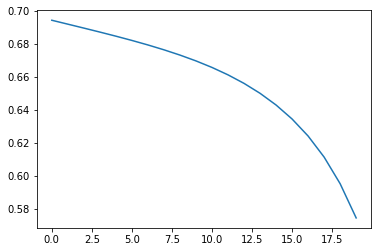

In [63]:
batch_per_file = 625
seq_length = 100
learning_rate = 1e-3
batch_size = 8
epochs = 1
num_workers = 0

df_chpn = df_meta[df_meta['composer'] == 'chpn'].iloc[1:]

dset = CombinedHands(df_meta=df_chpn.iloc[1:2], 
                     batch_size=batch_size, 
                     batch_per_file=batch_per_file,
                     seq_length=seq_length)
dataloader = DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=0)

model = PianoRollLSTM(separate=False)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model.to(device)

losses = []

for _ in range(epochs):
    
    for batch, (features, labels) in enumerate(dataloader):
        
        features = features.to(device)
        labels = labels.to(device)
        
        # compute prediction and loss
        pred = model(features)[0, :, :]
        loss = loss_fn(pred, labels)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(losses[-1])
        
        
plt.plot(losses)